# Intel® Array API Extension for Newton Fractals

### Patch original Numpy Array API with Intel® Extension for Array API

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import array_api_strict as np

### Define a method that converts color to grayscale 

In [3]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

### Load in and display an image of choice
Change file path accordingly

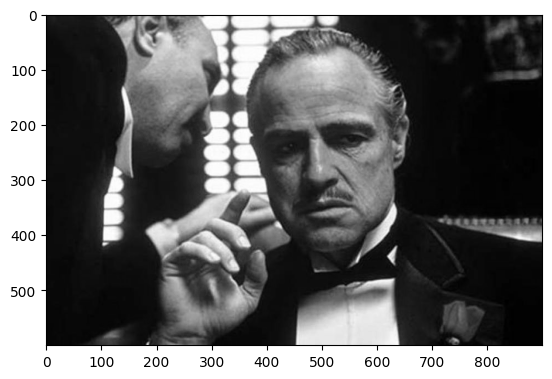

In [4]:
filename = "images/godfather.jpg" # fix file path here
img = mpimg.imread(filename)
img = rgb2gray(img)
plt.imshow(img, cmap='gray')

### Build Gaussan Kernel Function
Create a grid, and apply Gaussian formula 
$\\ G(x, y) = \frac{1}{2\pi \sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$

In [5]:
def gaussian_kernel(size, sigma=1):
    # Adjust size to ensure a center
    size = int(size) // 2
    # Grid of (x, y) coordinates in [-size, size] range
    x = np.arange(-size, size+1)
    y = np.arange(-size, size+1)
    x, y = np.meshgrid(x, y)
    # x, y = np.mgrid[-size:size+1, -size:size+1]
    sigmaSq = np.power(sigma, 2)
    # Norm coefficient
    normal = 1 / (2.0 * np.pi * sigmaSq)
    # Gaussian for (x,y) coords, pixel weight from center, sigma controls spread
    g =  np.exp(-((x**2 + y**2) / (2.0*sigmaSq))) * normal
    return g

### Convolve Function
$O(x, y) = \sum_{i=-1}^{1} \sum_{j=-1}^{1} I(x+i, y+j) \cdot K(-i, -j)$

O(x,y) is the output image at a specified position 

I(x+i,y+j) refers to the pixels of the input image that are being accessed based on the current kernel position.

K(−i,−j) refers to the kernel values, where the kernel is accessed with indices flipped both vertically and horizontally due to the convolution operation.

In [6]:
def convolve2d(image, kernel):
    """
    Apply a 2D convolution operation without padding.
    """
    output = np.zeros_like(np.asarray(image))  # Prepare the output array
    # Compute convolution
    for x in range(image.shape[1] - 2):
        for y in range(image.shape[0] - 2):
            # Apply elementwise multiplication and sum
            output[y+1, x+1] = (kernel[::-1, ::-1] * image[y:y+3, x:x+3]).sum()
    return output

### Filter Steps 
Sobel Kernels
$ K_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \quad K_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$ 

Gradient Magnitude
$ G = \sqrt{G_x^2 + G_y^2}, \quad \\ \text{Direction }\theta = \tan^{-1}\left(\frac{G_y}{G_x}\right) $



In [7]:
def sobel_filters(img):
    Kx = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # Convolve with Kx and Ky using custom convolve2d function
    Ix = convolve2d(img, Kx)
    Iy = convolve2d(img, Ky)
    
    # Compute gradient magnitude and direction
    G = np.sqrt(Ix**2 + Iy**2)
    G = G / np.max(G) * 255  # Normalize
    theta = np.atan2(Iy, Ix)  # Gradient direction
    
    return (G, theta)

### Plot Intermediate Images

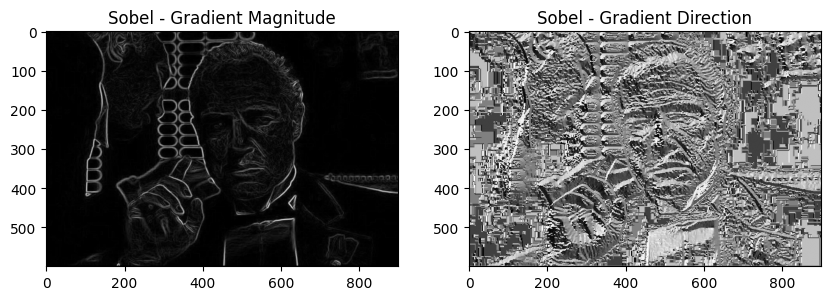

In [8]:
# Apply Sobel filter to the grayscale image
gradient_magnitude, gradient_direction = sobel_filters(img)

# Display the gradient magnitude as an image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Sobel - Gradient Magnitude")
plt.imshow(gradient_magnitude, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Sobel - Gradient Direction")
plt.imshow(gradient_direction, cmap='gray')

plt.show()

### Non-Max Suppression Function
Angle Conversion: Convert angles from radians to degrees and adjust for angles \< 0
$\\ \text{angle} = D \times \frac{180}{\pi} \\
\text{angle}[\text{angle} < 0] \text{ += } 180$

Neighbor Selection: Determine neighbors based on the angle using a piecewise function
$\\ \text{Let } (q, r) = 
\begin{cases} 
(\text{img}[i, j+1], \text{img}[i, j-1]) & \text{if } (0 \leq \text{angle}[i,j] < 22.5) \text{ or } (157.5 \leq \text{angle}[i,j] \leq 180) \\
(\text{img}[i+1, j-1], \text{img}[i-1, j+1]) & \text{if } (22.5 \leq \text{angle}[i,j] < 67.5) \\
(\text{img}[i+1, j], \text{img}[i-1, j]) & \text{if } (67.5 \leq \text{angle}[i,j] < 112.5) \\
(\text{img}[i-1, j-1], \text{img}[i+1, j+1]) & \text{if } (112.5 \leq \text{angle}[i,j] < 157.5)
\end{cases}$

Comparison and Suppression: Suppress the pixel at (i, j) if not greater than both neighbors along the gradient.
$\\ Z[i, j] = 
\begin{cases} 
\text{img}[i, j] & \text{if } \text{img}[i, j] \geq \max(q, r) \\
0 & \text{otherwise}
\end{cases}$


In [9]:
def non_max_suppression(img, D):
    # Initialize matrix of zeros with the same size as img
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    
    # Convert angles from radians to degrees and adjust negative angles
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    # Iterate through each pixel in the image
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                # Initialize comparison pixels to max value (placeholders)
                q = 255
                r = 255
                
                # Horizontal edge
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # Diagonal (positive slope) edge
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # Vertical edge
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # Diagonal (negative slope) edge
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                # Retain pixel if intensity is greater than neighbors along the gradient
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                # Ignore pixels where neighbors are out of bounds
                pass
    
    return Z

### Plot Intermediate Image

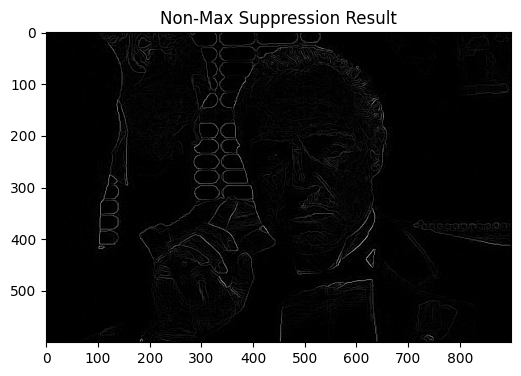

In [10]:
# Call the non_max_suppression function
suppressed_img = non_max_suppression(gradient_magnitude, gradient_direction)

# Display the resulting image
plt.figure(figsize=(6, 6))
plt.title("Non-Max Suppression Result")
plt.imshow(suppressed_img, cmap='gray')
plt.show()

### Threshold Function
`Threshold` function takes an image and two threshold ratios to compute thresholds based on the maximum pixel intensity of the image. The process can be described by the following equations:

$$\text{highThreshold} = \max(\text{img}) \times \text{highThresholdRatio}$$
$$\text{lowThreshold} = \text{highThreshold} \times \text{lowThresholdRatio}$$

It then classifies pixels into three categories based on their intensity:

- **Strong pixels:** Pixels with intensity greater than `highThreshold`. These are marked with the highest intensity value (255).
$$\text{Strong}(i, j) = \begin{cases} 
255 & \text{if } \text{img}(i, j) \geq \text{highThreshold} \\
0 & \text{otherwise}
\end{cases}$$

- **Weak pixels**: Pixels with intensity between `lowThreshold` and `highThreshold`. These are marked with a lower intensity value (25).
$$\text{Weak}(i, j) = \begin{cases}
25 & \text{if } \text{lowThreshold} \leq \text{img}(i, j) < \text{highThreshold} \\
0 & \text{otherwise}
\end{cases}$$

- **Non-relevant pixels**: Pixels with intensity less than `lowThreshold`. These remain zero in the output.
$$\text{Non-relevant}(i, j) = 0 \text{ if } \text{img}(i, j) < \text{lowThreshold}$$

In [15]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    # Maximum pixel intensity * highThresholdRatio
    img = np.asarray(img, dtype=np.float32)
    highThreshold = np.max(img) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    # Define intensity values for weak and strong pixels
    weak = np.asarray(25, dtype=np.float32)
    strong = np.asarray(255, dtype=np.float32)
    
    # Strong pixels 
    # strong_pixels = np.where(img >= highThreshold, img, strong)
    # strong_i, strong_j = np.nonzero(strong_pixels == strong)
    strong_pixels = img >= highThreshold
    strong_i, strong_j = np.nonzero(strong_pixels)
    res[strong_pixels] = strong
    # Non-relevant pixels
    # zeros_i, zeros_j = np.where(img < lowThreshold)
    
    # Weak pixels (in-between thresholds)
    # weak_pixels = np.where((img <= highThreshold) & (img >= lowThreshold), img, weak)
    # weak_i, weak_j = np.nonzero(weak_pixels == weak)
    weak_pixels = (img <= highThreshold) & (img >= lowThreshold)
    weak_i, weak_j = np.nonzero(weak_pixels)
    res[weak_pixels] = weak
    # Mark strong pixels with high intensity value
    # for i, j in zip(strong_i, strong_j):
    #     res[i, j] = strong
    # # Mark weak pixels with lower intensity value
    # for i, j in zip(weak_i, weak_j):
    #     res[i, j] = weak
    
    return (res, weak, strong)

### Plot Intermediate Image

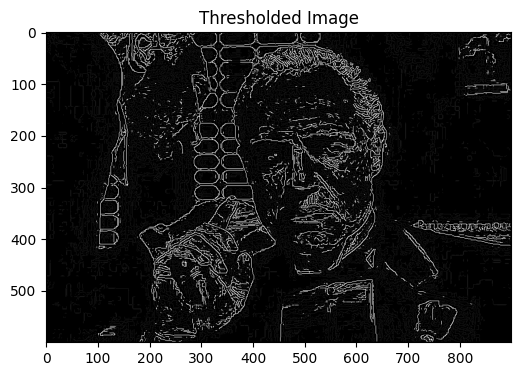

In [16]:
# Apply the threshold function to identify strong, weak, and non-relevant pixels
thresholded_img, weak, strong = threshold(suppressed_img)

# Display the thresholded image
plt.figure(figsize=(6, 6))
plt.title("Thresholded Image")
plt.imshow(thresholded_img, cmap='gray')
plt.show()

### Hysteresis Function
Iterate over each pixel in the image, excluding the border pixels, and process only weak pixels in `img`:
$$\text{for } i = 1 \text{ to } M-2 \text{ and } j = 1 \text{ to } N-2$$

For each weak pixel at position $(i, j)$, examine the eight surrounding pixels. If any of these neighboring pixels are strong, the weak pixel is changed to strong:
$$\text{if } \left( \text{img}[i+1, j-1] == \text{strong} \right) \text{ or } \dots \text{ or } \left( \text{img}[i-1, j+1] == \text{strong} \right)$$
$$\text{then img}[i, j] = \text{strong}$$

If no strong pixels are found around a weak pixel, it is set to zero (made non-relevant):
$$\text{else img}[i, j] = 0$$

In [17]:
# Apply hysteresis to identify strong pixels
def hysteresis(img):
    weak = np.asarray(25, dtype=np.int32)
    strong = np.asarray(255, dtype=np.int32)
    img = np.asarray(img, dtype=np.int32)
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            # Process only weak pixels
            if (img[i,j] == weak):
                try:
                    # Check surrounding pixels for a strong one
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        # Make weak pixel non-relevant if no strong pixel is around
                        img[i, j] = 0
                except IndexError as e:
                    print("something is wrong")
    return img

# Plot the final image!

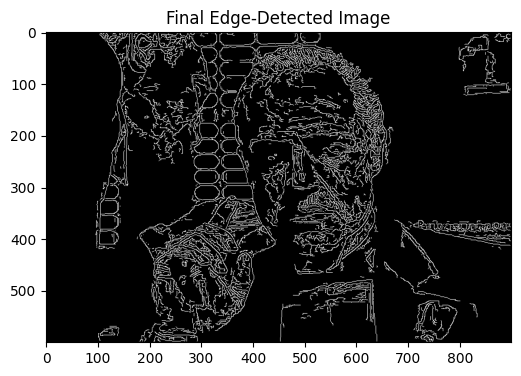

In [18]:
# Apply hysteresis to the thresholded image
final_img = hysteresis(thresholded_img)

# Display the final edge-detected image
plt.figure(figsize=(6, 6))
plt.title("Final Edge-Detected Image")
plt.imshow(final_img, cmap='gray')
plt.show()
